In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.model_selection import train_test_split

In [2]:
def burgers_equation(du_dt, du_dx, d2u_dx2, u, v):
    return du_dt + u * du_dx - v * d2u_dx2

In [3]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 50) 
        self.fc2 = nn.Linear(50, 50) 
        self.fc3 = nn.Linear(50, 50) 
        self.fc4 = nn.Linear(50, 50) 
        self.fc5 = nn.Linear(50, 1) 

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = self.fc5(x)
        return x

In [4]:
# Define the loss function
def loss_phys(u, x, t):
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    
    loss_phys = torch.mean((burgers_equation(u_t, u_x, u_xx, u, v) - 0)**2) 
    
    return loss_phys

In [5]:
def loss_data(u):  
    return torch.mean((u - u_train)**2)

In [6]:
def closure():
    optimizer.zero_grad() # Every epoch, reset calculations
    u_pred = model(torch.hstack((x_train, t_train)))
    loss = loss_phys(u_pred, x_train, t_train) + loss_data(u_pred) # Usually loss_data more impactful
    loss.backward() # Calculate the gradient of the loss 
    return loss

In [16]:
# Training function
def train(model, optimizer, num_epochs=10000):
    for epoch in range(1, num_epochs + 1):
        loss = optimizer.step(closure) # This is for LBFGS
        if epoch == 1 or epoch % 100 == 0 or epoch == num_epochs:
            print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}')

In [17]:
def plot(X, T, U, save_path = False, title=''):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, T, U, cmap='viridis')
    ax.set_xlabel('X')
    ax.set_ylabel('T')
    ax.set_zlabel('U')
    ax.set_title(title)
    if save_path:
        plt.savefig(title)
    plt.show()

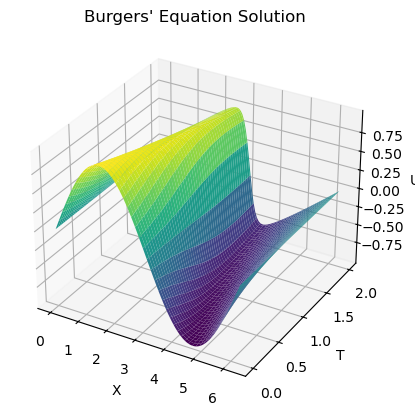

In [9]:
N = 100
v = 0.1 # Constant

x_max = 2 * np.pi
x_min = 0
t_max = 2
t_min = 0

x = np.linspace(x_min, x_max, N)
t = np.linspace(t_min, t_max, N)
t_span = (t_min, t_max)

u0 = np.sin(x)
dx = x[1] - x[0]
"""
Need to figure out how this is made, better if written in multiple code, but might lose precision
torch.autograd requires tensor inputs. 
Using autograd for numpy gives less accurate graphs.
"""
def solve_burgers(t, u, v):
    du_dt = np.zeros_like(u)
    du_dt[1:-1] = -u[1:-1] * (u[2:] - u[:-2]) / (2 * dx) + v * (u[2:] - 2 * u[1:-1] + u[:-2]) / dx**2
    return du_dt

# Solve the PDE using solve_ivp
sol = solve_ivp(solve_burgers, t_span, u0, t_eval=t, args=(v,), method='RK45')
U = sol.y.T

X, T = np.meshgrid(x, sol.t) # While solving for U, we also solve for the correct t values
plot(X, T, U, 'Burgers\' Equation Solution')

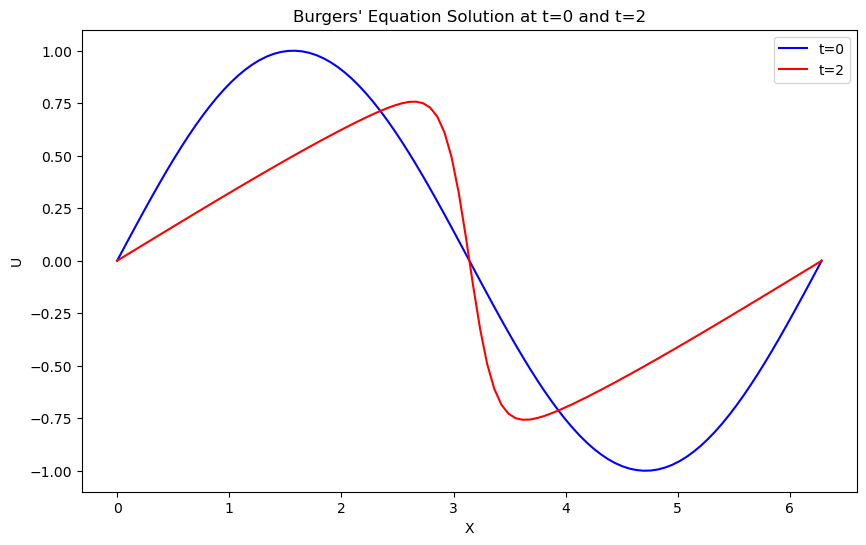

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(x, U[0, :], label='t=0', color='blue')
plt.plot(x, U[-1, :], label='t='+str(t_max), color='red')
plt.xlabel('X')
plt.ylabel('U')
plt.title('Burgers\' Equation Solution at t=0 and t='+str(t_max))
plt.legend()
plt.show()

In [13]:
X_flat = X.flatten()[:, None]
T_flat = T.flatten()[:, None]
U_flat = U.flatten()[:, None]

training_size = 5000
indices = np.random.choice(X_flat.shape[0], training_size, replace=False)

x_train = torch.tensor(X_flat[indices], dtype=torch.float32, requires_grad=True)
t_train = torch.tensor(T_flat[indices], dtype=torch.float32, requires_grad=True)
u_train = torch.tensor(U_flat[indices], dtype=torch.float32)

x_test = torch.tensor(X_flat, dtype=torch.float32)
t_test = torch.tensor(T_flat, dtype=torch.float32)
u_test = torch.tensor(U_flat, dtype=torch.float32)

In [14]:
# Initialize model and optimizer
model = PINN()

# LBFGS optimizer best for handling second derivative information and small datasets
# requires a closure() to perform the loss function multiple times, and be consistent
optimizer = optim.LBFGS(model.parameters(), lr=1)

# Train the model
train(model, optimizer)

Epoch [1/10000], Loss: 0.39415818452835083


KeyboardInterrupt: 

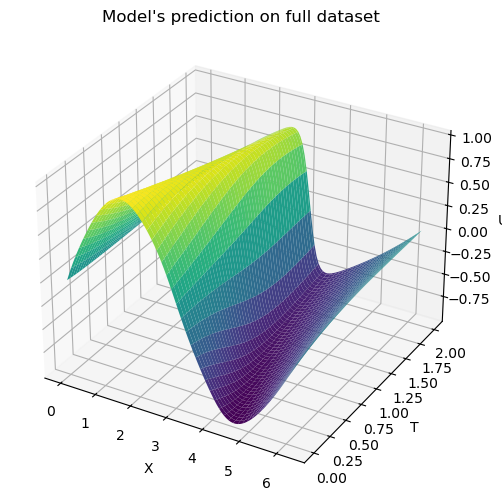

In [18]:
# test = torch.tensor(input_data, dtype=torch.float32)
# u_pred = model(test).detach().numpy().reshape(X.shape)
# plot(X, T, u_pred, 'Model\'s prediction on full dataset')

u_test = model(torch.hstack((x_test, t_test)))
U_plot = u_test.detach().numpy().reshape(X.shape)
plot(X, T, U_plot, True, 'Model\'s prediction on full dataset')